# **Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



## **Importing Skin Cancer Data**

### **Importing all the important libraries**


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.



In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


#### **Visualize the data**

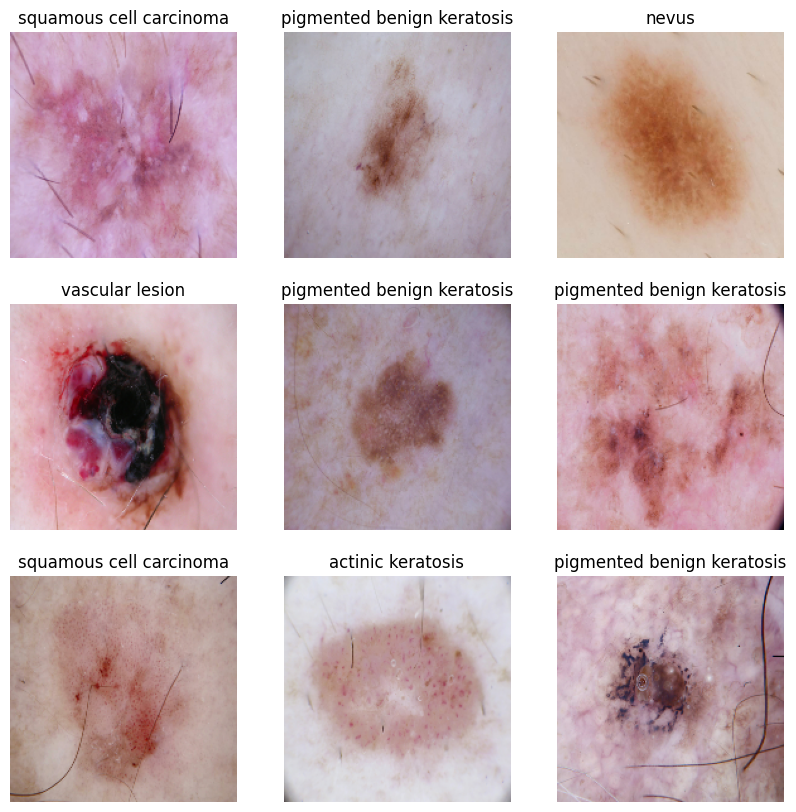

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [ ]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Create the model**
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]


In [ ]:
num_classes = 9

model = Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Compile the model**

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 1s 21ms/step - loss: 0.3504 - accuracy: 0.8661 - val_loss: 1.7818 - val_accuracy: 0.5189
Epoch 2/20
57/57 [==============================] - 1s 21ms/step - loss: 0.3162 - accuracy: 0.8800 - val_loss: 2.0227 - val_accuracy: 0.5412
Epoch 3/20
57/57 [==============================] - 1s 21ms/step - loss: 0.2969 - accuracy: 0.8878 - val_loss: 2.2333 - val_accuracy: 0.4410
Epoch 4/20
57/57 [==============================] - 1s 20ms/step - loss: 0.2961 - accuracy: 0.8861 - val_loss: 2.3314 - val_accuracy: 0.5345
Epoch 5/20
57/57 [==============================] - 1s 22ms/step - loss: 0.2381 - accuracy: 0.9050 - val_loss: 2.3129 - val_accuracy: 0.5100
Epoch 6/20
57/57 [==============================] - 2s 28ms/step - loss: 0.2214 - accuracy: 0.9050 - val_loss: 2.6730 - val_accuracy: 0.5234
Epoch 7/20
57/57 [==============================] - 1s 24ms/step - loss: 0.1854 - accuracy: 0.9172 - val_loss: 2.5421 - val_accuracy: 0.5390
Epoch 8/20
57

### **Visualize the model**

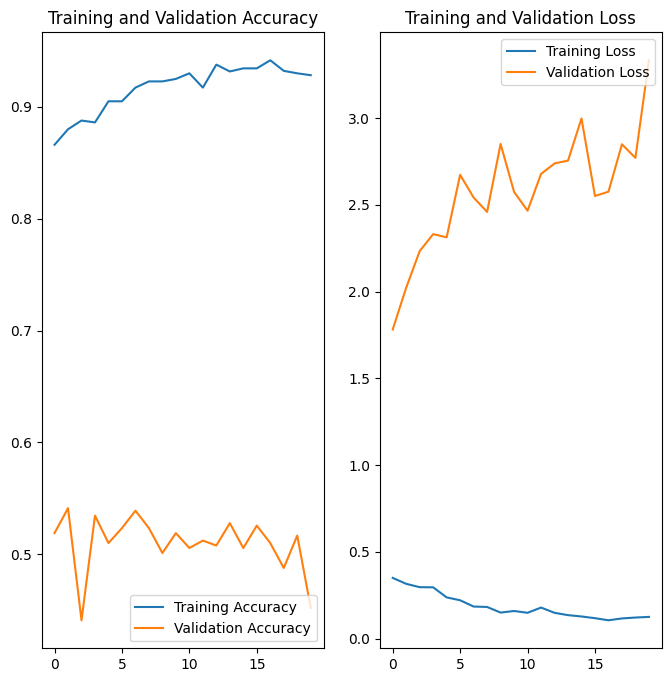

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

1. The training accuracy is initially 86% and validation accuracy is 51%, indicating the initial model learning from data
2. The sturdy training loss from 0.35 to 0.12 indicates that the model performing and predicting well in training data.
3. There is huge gap between training model accuracy and validation accuracy, indicates that model leads to overfitting.
4. Validation accuracy is 45% which indicates that model may not perform well with unseen data.












In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


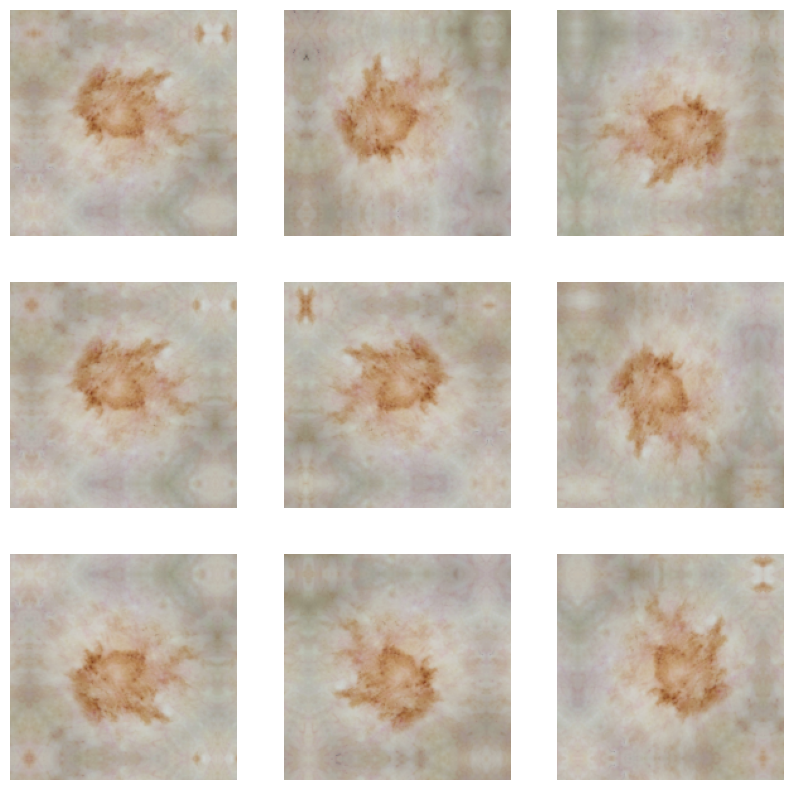

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augument(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### **Create the model, compile and train the model after data augmentation**


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augument,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### **Compiling the model**

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Training the model**


In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 13s 132ms/step - loss: 2.2955 - accuracy: 0.2272 - val_loss: 1.9004 - val_accuracy: 0.3252
Epoch 2/20
57/57 [==============================] - 7s 117ms/step - loss: 1.7884 - accuracy: 0.3344 - val_loss: 1.7268 - val_accuracy: 0.3563
Epoch 3/20
57/57 [==============================] - 7s 116ms/step - loss: 1.6356 - accuracy: 0.4133 - val_loss: 1.5498 - val_accuracy: 0.4276
Epoch 4/20
57/57 [==============================] - 7s 117ms/step - loss: 1.5149 - accuracy: 0.4628 - val_loss: 1.5075 - val_accuracy: 0.4655
Epoch 5/20
57/57 [==============================] - 7s 117ms/step - loss: 1.4738 - accuracy: 0.4967 - val_loss: 1.5334 - val_accuracy: 0.4766
Epoch 6/20
57/57 [==============================] - 7s 116ms/step - loss: 1.4210 - accuracy: 0.4983 - val_loss: 1.4440 - val_accuracy: 0.4922
Epoch 7/20
57/57 [==============================] - 7s 114ms/step - loss: 1.3949 - accuracy: 0.5089 - val_loss: 1.4733 - val_accuracy: 0.4878
Epoch

### **Visualizing the results**

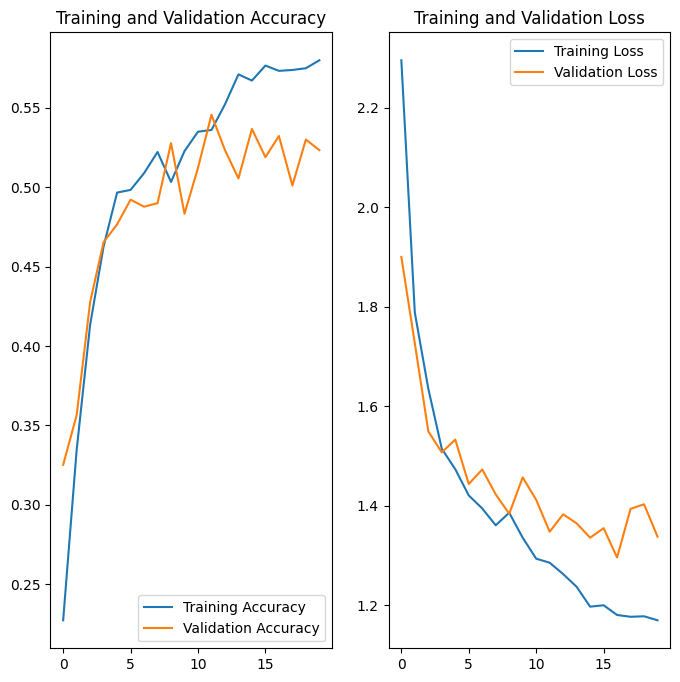

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Finding from Second Model**

1. There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation.
2. Accuracy comparitively lower than previous model.
3. Validation accuracy and training accuracy difference comparitively better that previous model.
4. Validation accuracy is still lower around 50% hence model is overfitting and may not perform well on unseen data.

**Todo**:

Find the distribution of classes in the training dataset.

**Context**:

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [ ]:
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
1,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
2,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
3,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
4,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2245,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2246,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2247,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion


Class=0, n=114 (5.069%)
Class=1, n=376 (16.719%)
Class=2, n=95 (4.224%)
Class=3, n=444 (19.742%)
Class=4, n=357 (15.874%)
Class=5, n=462 (20.542%)
Class=6, n=77 (3.424%)
Class=7, n=181 (8.048%)
Class=8, n=143 (6.358%)


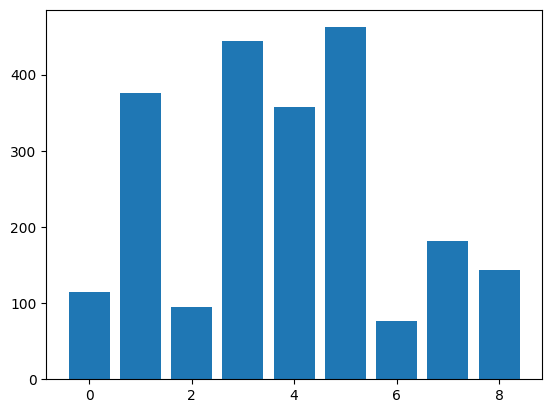

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# Count the number of samples per class
class_counts = original_df['Label'].value_counts()

# Find the class with the least number of samples
class_with_least_samples = class_counts.idxmin()

# Calculate the proportion of samples for each class
class_proportions = class_counts / len(original_df)

# Display the number of samples per class as a table
class_table = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values,
    'Proportion': class_proportions.values
})

class_table


,Class,Count,Proportion
0,pigmented benign keratosis,462,0.205425
1,melanoma,444,0.197421
2,basal cell carcinoma,376,0.167185
3,nevus,357,0.158737
4,squamous cell carcinoma,181,0.080480
5,vascular lesion,143,0.063584
6,actinic keratosis,114,0.050689
7,dermatofibroma,95,0.042241
8,seborrheic keratosis,77,0.034237


**Findings:**

1. Seborrheic keratosis	has the least number of samples with around 0.03%.

2. Pigmented benign keratosis	and Melanoma classes dominates the data with around 20% and 19% respectively.



## **Rectifying class imbalance**

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(str(path_to_training_dataset), i), save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18E1FC9000>: 100%|██████████| 500/500 [00:25<00:00, 19.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18E1D2CE50>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18E1276B90>: 100%|██████████| 500/500 [00:25<00:00, 19.81 Samples/s]


Initialised with 444 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F18E1204B20>: 100%|██████████| 500/500 [02:00<00:00,  4.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7F18E121F0D0>: 100%|██████████| 500/500 [01:56<00:00,  4.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18E12E3B50>: 100%|██████████| 500/500 [00:24<00:00, 20.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F18E12784C0>: 100%|██████████| 500/500 [00:56<00:00,  8.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18F0ED14B0>: 100%|██████████| 500/500 [00:23<00:00, 20.99 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18E12B6C20>: 100%|██████████| 500/500 [00:25<00:00, 19.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.



In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


In [ ]:
class_image_count = {}

for i in class_names:
  # Augmentor has created 'output' subdirectory in each class directory
  class_dir = os.path.join(str(data_dir_train), i, 'output')

  # Get list of all files in the directory
  file_list = os.listdir(class_dir)

  # Count number of images (assuming they are all .jpg files)
  num_images = len([f for f in file_list if f.endswith('.jpg')])

  # Save results into dictionary
  class_image_count[i] = num_images

# Convert the dictionary to dataframe
df = pd.DataFrame(list(class_image_count.items()), columns=['Class', 'Number of Augmented Images'])

df

,Class,Number of Augmented Images
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


**Lets see the distribution of augmented data after adding new images to the original training data**

In [ ]:
from pathlib import Path

# Empty lists to hold file paths and corresponding classes
path_list = []
class_list = []

# Directory path for the augmented images
data_dir_train_output = Path(data_dir_train)

# Loop over each class
for class_folder in data_dir_train_output.iterdir():
    if class_folder.is_dir():
        # Get list of all .jpg files in the main directory
        for image_path in class_folder.glob('*.jpg'):
            # Append file path and class to respective lists
            path_list.append(str(image_path))
            class_list.append(class_folder.name)

        output_folder = class_folder / 'output'
        if output_folder.exists() and output_folder.is_dir():
            # Get list of all .jpg files in the output directory
            for image_path in output_folder.glob('*.jpg'):
                # Append file path and class to respective lists
                path_list.append(str(image_path))
                class_list.append(class_folder.name)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Path': path_list,
    'Class': class_list,
})

df


,Path,Class
0,/content/gdrive/MyDrive/Train/dermatofibroma/I...,dermatofibroma
1,/content/gdrive/MyDrive/Train/dermatofibroma/I...,dermatofibroma
2,/content/gdrive/MyDrive/Train/dermatofibroma/I...,dermatofibroma
3,/content/gdrive/MyDrive/Train/dermatofibroma/I...,dermatofibroma
4,/content/gdrive/MyDrive/Train/dermatofibroma/I...,dermatofibroma
...,...,...
6744,/content/gdrive/MyDrive/Train/pigmented benign...,pigmented benign keratosis
6745,/content/gdrive/MyDrive/Train/pigmented benign...,pigmented benign keratosis
6746,/content/gdrive/MyDrive/Train/pigmented benign...,pigmented benign keratosis
6747,/content/gdrive/MyDrive/Train/pigmented benign...,pigmented benign keratosis


In [ ]:
df['Class'].value_counts()


pigmented benign keratosis    962
melanoma                      944
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               643
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Class, dtype: int64

### **Train the model on the data created using Augmentor**


In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/Train')

#### **Training Dataset**

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Validation Dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Creating Model with normalization**

In [ ]:
num_classes = 9

model = Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    #Dropout layer with 20% Fraction of the input units to drop.
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])


### **Compile the model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

#### **Training the model**

In [ ]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 42s 217ms/step - loss: 1.7661 - accuracy: 0.3230 - val_loss: 1.4683 - val_accuracy: 0.4522
Epoch 2/30
169/169 [==============================] - 39s 215ms/step - loss: 1.4759 - accuracy: 0.4263 - val_loss: 1.3699 - val_accuracy: 0.4685
Epoch 3/30
169/169 [==============================] - 39s 222ms/step - loss: 1.3592 - accuracy: 0.4791 - val_loss: 1.2415 - val_accuracy: 0.5248
Epoch 4/30
169/169 [==============================] - 39s 222ms/step - loss: 1.2052 - accuracy: 0.5426 - val_loss: 1.1702 - val_accuracy: 0.5641
Epoch 5/30
169/169 [==============================] - 41s 233ms/step - loss: 1.0922 - accuracy: 0.5828 - val_loss: 1.0346 - val_accuracy: 0.6212
Epoch 6/30
169/169 [==============================] - 41s 234ms/step - loss: 0.9276 - accuracy: 0.6511 - val_loss: 1.0408 - val_accuracy: 0.6168
Epoch 7/30
169/169 [==============================] - 37s 210ms/step - loss: 0.8050 - accuracy: 0.6994 - val_loss: 0.9062 - val_accuracy: 0.6

#### **Visualize the model**

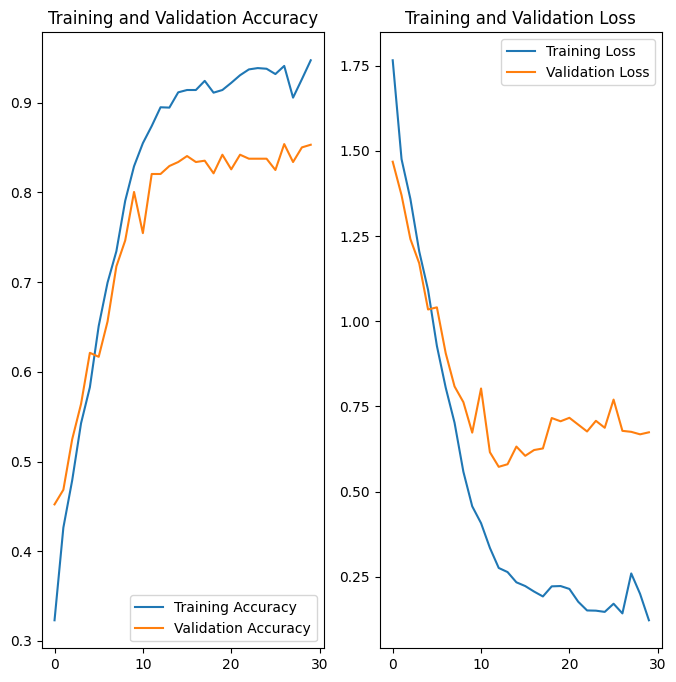

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Conclusion:**

**Did you get rid of underfitting/overfitting?**

1. Indication of underfitting includes poor performs on training data itself. Here training model accuracy is above 90% hence model performs well on training model

2. Indication of overfitting includes poor performs on validation data. the validation loss starts increasing while the training loss continues to decrease. This is a sign of overfitting as it shows the model is continuing to adapt itself to the training data (hence the decreasing training loss) but is performing worse on the validation data (hence the increasing validation loss)

**Did Class rebalance help?**

From the results, the model's accuracy is approximately 94% on the training data and 85% on the validation data, indicating good overall performance. This suggests that class rebalancing may have been beneficial.


